In [57]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import quad
import math
import warnings
from multiprocessing import Pool
warnings.filterwarnings("ignore")
Mpc = 3.0857e22  # Mega parsec in meters

figuresize = 4
plt.rcParams["figure.figsize"] = (figuresize, figuresize*9.7/12)
plt.rcParams["axes.unicode_minus"] = False
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['text.usetex'] = False

# Temperature chnage

The temperature change of the CMB due to scattering of CMB photons on moving intrercluster gas will be calculated in the following.

## Parameters definition
define all parameters of the galaxy cluster:

- `r_c` core radius
- `r` border radius
- `n_eo` electron delsity
- `d` distance to the observer

parameters for the velocity profiles VP1 & VP2:
- `v_c` core velocity for VP1 in units of c
- `r_0` scale radius for VP2
- `v_t` scale velocity for VP2 in units of c

Inclination `inclination`$\in (0, 1/2)$ in units of $\pi$
and rotation along the line of sight `ry`$\in (0, 2\pi)$.
Rotation along z axis `rz` stays zero

In [58]:
r_c = 0.2 * Mpc  # core radius
r = 2.8 * Mpc  # maximum radius

n_eo = 2e4  # central electron density
d = 1e6 * Mpc  # distance

# parameters for VP1 & VP2
v_c = 5e-4/3
r_0 = 1.2 * Mpc
v_t = 8e-3/3

# rotation angles
inclination = 1/2
ry = 0  # rotation angle y-axis - line of sight
rx = np.pi * (1/2 - inclination) # rotation angle x-axis - horizontal axis
rz = 0  # rotation angle z-axis - vertical axis

define parameters for images. Resolution `e` along x axis. `e²` points are integrated -> calculation time increases $\sim e^2$.

Viewing angles `c`. $r/d$ corresponds to core radius.

In [59]:
e = 8*32  # Resolution
c = r/d*1.05  # edge limit (angle). r/d is angle for max. radius r

Define CMB temperature & Thompson cross-section

In [60]:
sigma_T = 6.652e-29  # thomson cross section
T = 2.725  # CMB temperature

beta = 2/3  # for beta model

## Function definition

### Electron density
 - `beta_model`
 - `n_e` model from *Vikhlinin*

In [61]:
def beta_model(x, y, z, n_eo, r_c, beta):
    return n_eo*(1+(x**2+y**2+z**2)/r_c**2)**(-beta * 3/2)


def n_e(x, y, z, n_eo, r_c, beta):
    r = np.sqrt(x**2+y**2+z**2)/r_c
    r_s = 1.7 * Mpc
    alpha = 1
    beta = 0.7
    epsilon = 2.5
    return n_eo*r**(-alpha / 2) / (1+r**2)**(3*beta/2 - alpha/2) / (1+(r*r_c/r_s)**3)**(epsilon/2/3)

### Integrands
for relative intensity chnage with VP1 and VP2

In [62]:
def integrand_tempChange_VP1(t, d, theta, phi, n_eo, r_c, beta, rot):
    return T * sigma_T * np.dot(VP1(theta*t, t-d, phi*t, rot), np.array([theta, 1, phi])) * n_e(theta*t, t-d, phi*t, n_eo, r_c, beta)


def integrand_tempChange_VP2(t, d, theta, phi, n_eo, r_c, beta, rot):
    return T * sigma_T * np.dot(VP2(theta*t, t-d, phi*t, rot), np.array([theta, 1, phi])) * n_e(theta*t, t-d, phi*t, n_eo, r_c, beta)

### Velocity profiles and rotation (inclination)

rotationg velocity vector field with VP1 and VP2. Rotated by an rotation matrix to match inclination and rotation along the line of sight defined above

In [63]:
def rotMatrix(rx, ry, rz):  # create rotation matrix
    rotx = [[1, 0, 0],
            [0, np.cos(rx), np.sin(rx)],
            [0, -np.sin(rx), np.cos(rx)]]
    roty = [[np.cos(ry), 0, np.sin(ry)],
            [0, 1, 0],
            [-np.sin(ry), 0, np.cos(ry)]]
    rotz = [[np.cos(rz), np.sin(rz), 0],
            [-np.sin(rz), np.cos(rz), 0],
            [0, 0, 1]]
    # firt x-axis, the z-axis, last y-axis. (Keep z-rot = 0)
    rot = np.matmul(roty, np.matmul(rotz, rotx))
    rot[np.abs(rot) < 1e-5] = 0
    return rot.copy()


def rotate(x, y, z, rot):  # rotate koordinates rot^T * vec(r) = vec(r_rot)
    rotXYZ = np.transpose(
        np.matmul(np.transpose(rot), np.array([[x], [y], [z]])))[0]
    return rotXYZ[0], rotXYZ[1], rotXYZ[2]


def VP1(x, y, z, rot):  # Velocity profile 1 - vctor field, rotated
    x, y, z = rotate(x, y, z, rot)
    v_norm = np.transpose(np.matmul(rot, np.array(
        [[-y], [x], [0]])))[0].copy() / np.sqrt(x**2+y**2)  # normalized field
    r = np.sqrt(x**2+y**2)/r_c  # r/r_c
    v = v_c * r  # profile
    return v * v_norm


def VP2(x, y, z, rot):  # Velocity profile 2 - vctor field, rotated
    x, y, z = rotate(x, y, z, rot)
    v_norm = np.transpose(np.matmul(rot, np.array(
        [[-y], [x], [0]])))[0].copy() / np.sqrt(x**2+y**2)  # normalized field
    r = np.sqrt(x**2+y**2)/r_0  # r/r_0
    v = v_t * r / (1+r**2)  # Profile
    return v * v_norm

### Integradion function
Integrate integrand `integr` with `args`

In [64]:
def integrate(args):
    Result[Result != 0] = 0
    integr, t1, t2, d, Theta, Phi, n_eo, r_c, beta, rot, threats = args[0], args[1],  args[
        2],  args[3],  args[4],  args[5],  args[6],  args[7],  args[8],  args[9],  args[10]
    section_x = args[11]
    section_y = args[12]
    sectionsize = int(e/threats)
    for i in range(sectionsize*section_x, sectionsize*(section_x+1)):
        for j in range(sectionsize*section_y, sectionsize*(section_y+1)):
            theta = Theta[i, j]
            phi = Phi[i, j]
            I = quad(integr, t1[i, j], t2[i, j], args=(
                d, theta, phi, n_eo, r_c, beta, rot))
            Result[i, j] = np.around(I[0], decimals=10)
    return Result.copy()

## Calculation
### Limits
Prepare vairables for calculation

calculate limits t1, t2 for integration along the line of sight. The limits match the galaxy cluster radius along the line of sight.

create the rotation maxtix

In [65]:
# generate variables for calculation
theta = np.linspace(-c, c, e)
Theta, Phi = np.meshgrid(theta, theta)
Result = Theta.copy()
t = np.linspace(0, 0, e)
t1, t2 = np.meshgrid(t, t)

# limits for integral. edge of cluster
t1 = (d - np.sqrt(-d**2 * (Phi**2 + Theta**2) + r**2
      * (1 + Phi**2 + Theta**2)))/(1 + Phi**2 + Theta**2)
t2 = (d + np.sqrt(-d**2 * (Phi**2 + Theta**2) + r**2
      * (1 + Phi**2 + Theta**2)))/(1 + Phi**2 + Theta**2)

# calculate rotation matrix
rot = rotMatrix(rx, ry, rz)

### integrate
execute the calculation for all angles for VP2. With multiprozessing to speed up calculation

In [66]:
# integrate parallel in 8  threats for VP2
thrts = 8
if __name__ == '__main__':
    with Pool() as pool:
        results = pool.map(integrate, [(integrand_tempChange_VP2, t1, t2, d, Theta, Phi, n_eo,
                           r_c, beta, rot, thrts, i, j) for i in range(thrts) for j in range(thrts)])

# merge threat  results
tempChange, tempChange = np.meshgrid(t, t)
for i in range(len(results)):
    q = results[i]
    tempChange += q


## Plots
### svg's
Generate plot and save as svg with latex text.

In [67]:
tempChange[tempChange == 0] = np.NaN
plt.rcParams.update({"text.usetex": False})
# relative intesity plot for VP1 -----------------------------------------------
plt.contourf(Theta*d/r_c, Phi*d/r_c, tempChange*1e6, 100, cmap='coolwarm')
plt.colorbar().set_label("\$\Delta T / \mu \mathrm{K}\$", labelpad=-15, y=1.07, rotation=0)
plt.xlabel("x / \$r_c\$")
plt.ylabel("z / \$r_c\$")
plt.savefig("figs/tempchange_VP2.svg")
plt.close()


# set nan values to 0 & return max values --------------------------------------
tempChange[np.isnan(tempChange)] = 0.
print(np.max(tempChange[int(e/2)]))

# plot cut at x-axis (normalized) ----------------------------------------------
plt.plot(Theta[int(e/2)]*d/r_c, tempChange[int(e/2)]*1e6, c='black')
plt.rcParams.update({"text.usetex": True})
plt.ylabel("\$\Delta T / \mu \mathrm{K}\$")
plt.xlabel("x / \$r_c\$")
plt.savefig("figs/tempchange2d_VP2.svg")
plt.close()

2.89194e-05


### show

generate plots again but show them this time (optional export as PNG)

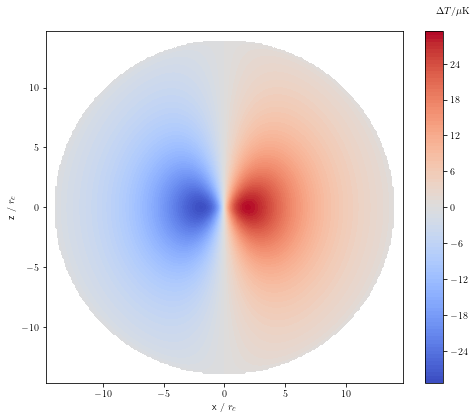

2.89194e-05


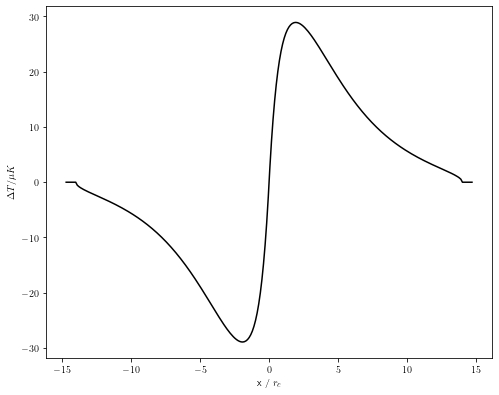

In [68]:
figuresize = 8
plt.rcParams["figure.figsize"] = (figuresize, figuresize*9.7/12)
plt.rcParams.update({"text.usetex": True})

tempChange[tempChange == 0] = np.NaN
# relative intesity plot for VP1 -----------------------------------------------
plt.contourf(Theta*d/r_c, Phi*d/r_c, tempChange*1e6, 100, cmap='coolwarm')
plt.colorbar().set_label("$\Delta T / \mu \mathrm{K}$", labelpad=-15, y=1.07, rotation=0)
plt.xlabel("x / $r_c$")
plt.ylabel("z / $r_c$")
# plt.savefig("figs/tempchange_VP2.png")
plt.show()


# set nan values to 0 & return max values --------------------------------------
tempChange[np.isnan(tempChange)] = 0.
print(np.max(tempChange[int(e/2)]))

# plot cut at x-axis (normalized) ----------------------------------------------
plt.plot(Theta[int(e/2)]*d/r_c, tempChange[int(e/2)]*1e6, c='black')
plt.ylabel("$\Delta T / \mu K$")
plt.xlabel("x / $r_c$")
# plt.savefig("figs/tempchange2d_VP2.png")
plt.show()